In [1]:
%pip install SimpleITK


   ---------------------------------------- 0.0/18.7 MB ? eta -:--:--
   - -------------------------------------- 0.8/18.7 MB 8.5 MB/s eta 0:00:03
   ---------------- ----------------------- 7.9/18.7 MB 24.4 MB/s eta 0:00:01
   ------------------------------------- -- 17.6/18.7 MB 33.6 MB/s eta 0:00:01
   ---------------------------------------- 18.7/18.7 MB 25.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from IPython.display import clear_output
from skimage.util import img_as_ubyte

In [5]:
def imshow_orthogonal_view(sitkImage, origin = None, title=None):
    """
    Display the orthogonal views of a 3D volume from the middle of the volume.

    Parameters
    ----------
    sitkImage : SimpleITK image
        Image to display.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    data = sitk.GetArrayFromImage(sitkImage)

    if origin is None:
        origin = np.array(data.shape) // 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    data = img_as_ubyte(data/np.max(data))
    axes[0].imshow(data[origin[0], ::-1, ::-1], cmap='gray')
    axes[0].set_title('Axial')

    axes[1].imshow(data[::-1, origin[1], ::-1], cmap='gray')
    axes[1].set_title('Coronal')

    axes[2].imshow(data[::-1, ::-1, origin[2]], cmap='gray')
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

def overlay_slices(sitkImage0, sitkImage1, origin = None, title=None):
    """
    Overlay the orthogonal views of a two 3D volume from the middle of the volume.
    The two volumes must have the same shape. The first volume is displayed in red,
    the second in green.

    Parameters
    ----------
    sitkImage0 : SimpleITK image
        Image to display in red.
    sitkImage1 : SimpleITK image
        Image to display in green.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    vol0 = sitk.GetArrayFromImage(sitkImage0)
    vol1 = sitk.GetArrayFromImage(sitkImage1)

    if vol0.shape != vol1.shape:
        raise ValueError('The two volumes must have the same shape.')
    if np.min(vol0) < 0 or np.min(vol1) < 0: # Remove negative values - Relevant for the noisy images
        vol0[vol0 < 0] = 0
        vol1[vol1 < 0] = 0
    if origin is None:
        origin = np.array(vol0.shape) // 2

    sh = vol0.shape
    R = img_as_ubyte(vol0/np.max(vol0))
    G = img_as_ubyte(vol1/np.max(vol1))

    vol_rgb = np.zeros(shape=(sh[0], sh[1], sh[2], 3), dtype=np.uint8)
    vol_rgb[:, :, :, 0] = R
    vol_rgb[:, :, :, 1] = G

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(vol_rgb[origin[0], ::-1, ::-1, :])
    axes[0].set_title('Axial')

    axes[1].imshow(vol_rgb[::-1, origin[1], ::-1, :])
    axes[1].set_title('Coronal')

    axes[2].imshow(vol_rgb[::-1, ::-1, origin[2], :])
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

def composite2affine(composite_transform, result_center=None):
    """
    Combine all of the composite transformation's contents to form an equivalent affine transformation.
    Args:
        composite_transform (SimpleITK.CompositeTransform): Input composite transform which contains only
                                                            global transformations, possibly nested.
        result_center (tuple,list): The desired center parameter for the resulting affine transformation.
                                    If None, then set to [0,...]. This can be any arbitrary value, as it is
                                    possible to change the transform center without changing the transformation
                                    effect.
    Returns:
        SimpleITK.AffineTransform: Affine transformation that has the same effect as the input composite_transform.
    
    Source:
        https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/22_Transforms.ipynb
    """
    # Flatten the copy of the composite transform, so no nested composites.
    flattened_composite_transform = sitk.CompositeTransform(composite_transform)
    flattened_composite_transform.FlattenTransform()
    tx_dim = flattened_composite_transform.GetDimension()
    A = np.eye(tx_dim)
    c = np.zeros(tx_dim) if result_center is None else result_center
    t = np.zeros(tx_dim)
    for i in range(flattened_composite_transform.GetNumberOfTransforms() - 1, -1, -1):
        curr_tx = flattened_composite_transform.GetNthTransform(i).Downcast()
        # The TranslationTransform interface is different from other
        # global transformations.
        if curr_tx.GetTransformEnum() == sitk.sitkTranslation:
            A_curr = np.eye(tx_dim)
            t_curr = np.asarray(curr_tx.GetOffset())
            c_curr = np.zeros(tx_dim)
        else:
            A_curr = np.asarray(curr_tx.GetMatrix()).reshape(tx_dim, tx_dim)
            c_curr = np.asarray(curr_tx.GetCenter())
            # Some global transformations do not have a translation
            # (e.g. ScaleTransform, VersorTransform)
            get_translation = getattr(curr_tx, "GetTranslation", None)
            if get_translation is not None:
                t_curr = np.asarray(get_translation())
            else:
                t_curr = np.zeros(tx_dim)
        A = np.dot(A_curr, A)
        t = np.dot(A_curr, t + c - c_curr) + t_curr + c_curr - c

    return sitk.AffineTransform(A.flatten(), t, c)

# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

def command_iteration(method):
    print(
        f"{method.GetOptimizerIteration():3} "
        + f"= {method.GetMetricValue():10.5f} "
        + f": {method.GetOptimizerPosition()}"
    )

## Exercise 1

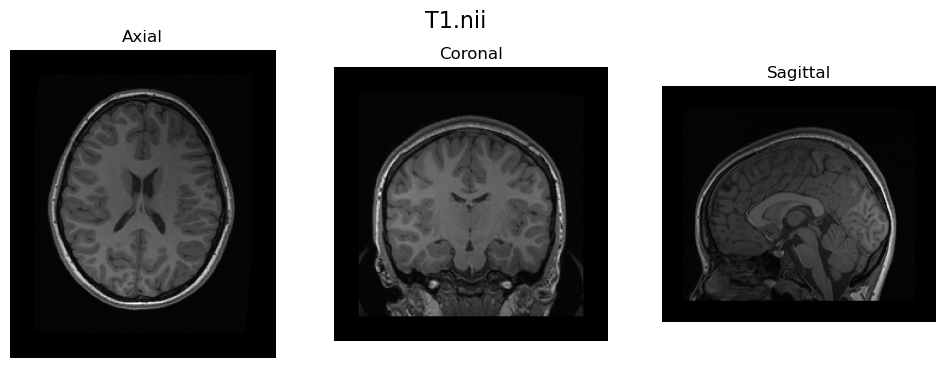

In [6]:
dir_in = 'data/'
vol_sitk = sitk.ReadImage(dir_in + 'ImgT1.nii')

# Display the volume
imshow_orthogonal_view(vol_sitk, title='T1.nii')

## Exercise 2

In [ ]:
def rotation_matrix(pitch, roll, yaw):
    """
    Create a rotation matrix from pitch, roll and yaw angles.
    The rotation is applied in the order: pitch, roll, yaw.
    
    Parameters
    ----------
    pitch : float
        Rotation around the x-axis.
    roll : float
        Rotation around the y-axis.
    yaw : float
        Rotation around the z-axis.
    
    Returns
    -------
    numpy.ndarray
        Rotation matrix.
    """
    # Convert angles to radians
    pitch = np.radians(pitch)
    roll = np.radians(roll)
    yaw = np.radians(yaw)
    
    # Rotation matrix around x-axis (pitch)
    R_x = np.array([[1, 0, 0],
                    [0, np.cos(pitch), -np.sin(pitch)],
                    [0, np.sin(pitch), np.cos(pitch)]])
    
    # Rotation matrix around y-axis (roll)
    R_y = np.array([[np.cos(roll), 0, np.sin(roll)],
                    [0, 1, 0],
                    [-np.sin(roll), 0, np.cos(roll)]])
    
    # Rotation matrix around z-axis (yaw)
    R_z = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                    [np.sin(yaw), np.cos(yaw), 0],
                    [0, 0, 1]])
    
    # Combine the three rotations
    R = np.dot(R_z, np.dot(R_y, R_x))
    
    return R




## Exercise 3


In [8]:
# Define the roll rotation in radians
pitch = 25  # degrees


# Create the Affine transform and set the rotation
transform = sitk.AffineTransform(3)

centre_image = np.array(vol_sitk.GetSize()) / 2 - 0.5 # Image Coordinate System
centre_world = vol_sitk.TransformContinuousIndexToPhysicalPoint(centre_image) # World Coordinate System
rot_matrix = rotation_matrix(pitch, 0, 0)[:3, :3] # SimpleITK inputs the rotation and the translation separately

transform.SetCenter(centre_world) # Set the rotation centre
transform.SetMatrix(rot_matrix.T.flatten())

# Apply the transformation to the image
ImgT1_A = sitk.Resample(vol_sitk, transform)

# Save the rotated image
sitk.WriteImage(ImgT1_A, dir_in + 'ImgT1_A.nii')

## Exercise 4

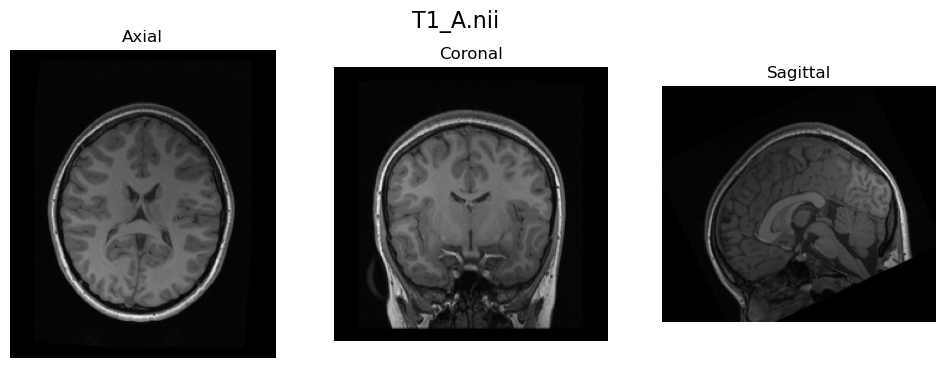

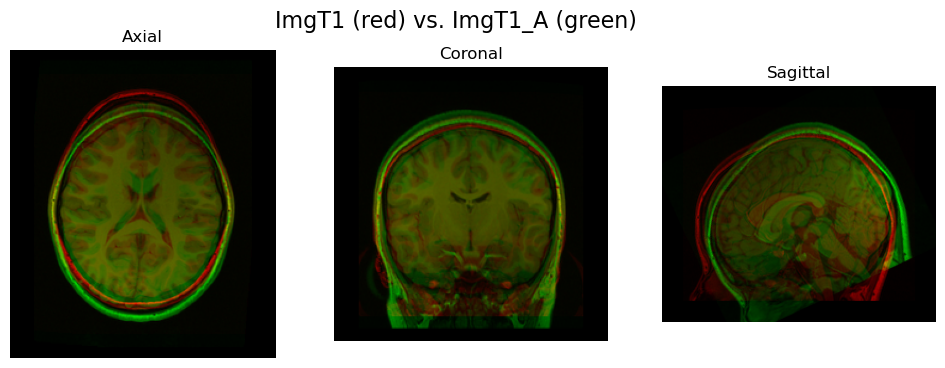

In [9]:
imshow_orthogonal_view(ImgT1_A, title='T1_A.nii')
overlay_slices(vol_sitk, ImgT1_A, title = 'ImgT1 (red) vs. ImgT1_A (green)')

## Exercise 5

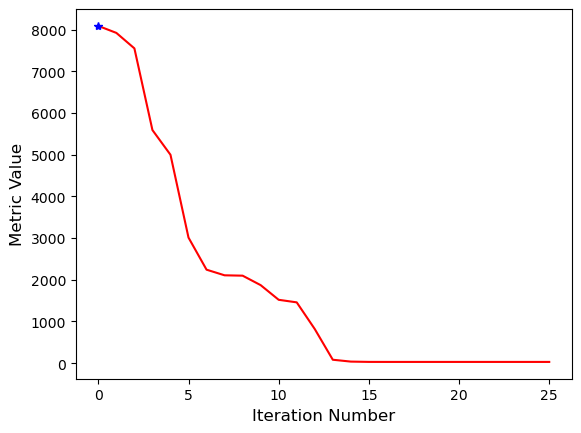

In [10]:
moving_image = ImgT1_A
fixed_image = vol_sitk

# Set the registration - Fig. 1 from the Theory Note
R = sitk.ImageRegistrationMethod()

# Set a one-level the pyramid scheule. [Pyramid step]
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the interpolator [Interpolation step]
R.SetInterpolator(sitk.sitkLinear)

# Set the similarity metric [Metric step]
R.SetMetricAsMeanSquares()

# Set the sampling strategy [Sampling step]
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.50)

# Set the optimizer [Optimization step]
R.SetOptimizerAsPowell(stepLength=0.1, numberOfIterations=25)

# Initialize the transformation type to rigid 
initTransform = sitk.Euler3DTransform()
R.SetInitialTransform(initTransform, inPlace=False)

# Some extra functions to keep track to the optimization process 
# R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R)) # Print the iteration number and metric value
R.AddCommand(sitk.sitkStartEvent, start_plot) # Plot the similarity metric values across iterations
R.AddCommand(sitk.sitkEndEvent, end_plot)
R.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
R.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(R))

# Estimate the registration transformation [metric, optimizer, transform]
tform_reg = R.Execute(fixed_image, moving_image)

# Apply the estimated transformation to the moving image
ImgT1_B = sitk.Resample(moving_image, tform_reg)

# Save 
sitk.WriteImage(ImgT1_B, dir_in + 'ImgT1_B.nii')

## Exercise 6

In [11]:
estimated_tform = tform_reg.GetNthTransform(0).GetMatrix() # Transform matrix
estimated_translation = tform_reg.GetNthTransform(0).GetTranslation() # Translation vector
params = tform_reg.GetParameters() # Parameters (Rx, Ry, Rz, Tx, Ty, Tz)

def homogeneous_matrix_from_transform(transform):
    """Convert a SimpleITK transform to a homogeneous matrix."""
    matrix = np.zeros((4, 4))
    matrix[:3, :3] = np.reshape(np.array(transform.GetMatrix()), (3, 3))
    matrix[:3, 3] = transform.GetTranslation()
    matrix[3, 3] = 1
    return matrix

matrix_estimated = homogeneous_matrix_from_transform(tform_reg.GetNthTransform(0))
matrix_applied = homogeneous_matrix_from_transform(transform)

tform_reg.WriteTransform(dir_in + 'A1.tfm')
tform_loaded = sitk.ReadTransform(dir_in + 'A1.tfm')

Estimated Transformation Matrix
[[ 1.00000000e+00  1.08059350e-05 -1.79946313e-05  1.13100344e-03]
 [-1.73988716e-05  9.06289473e-01 -4.22657533e-01  1.11651414e+01]
 [ 1.17411351e-05  4.22657533e-01  9.06289473e-01  3.06333621e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Applied Transformation Matrix
[[ 1.          0.          0.          0.        ]
 [ 0.          0.90630779  0.42261826  0.        ]
 [ 0.         -0.42261826  0.90630779  0.        ]
 [ 0.          0.          0.          1.        ]]
itk::simple::CompositeTransform
 CompositeTransform (000001A9CC56C770)
   RTTI typeinfo:   class itk::CompositeTransform<double,3>
   Reference Count: 1
   Modified Time: 1601704
   Debug: Off
   Object Name: 
   Observers: 
     none
   TransformQueue: 
   >>>>>>>>>
   Euler3DTransform (000001A9CC431CC0)
     RTTI typeinfo:   class itk::Euler3DTransform<double>
     Reference Count: 1
     Modified Time: 1601700
     Debug: Off
     Object Name: 
     Observ

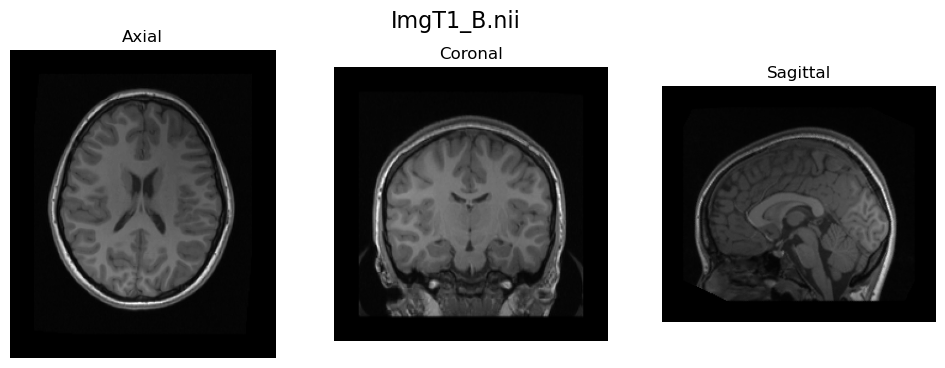

In [14]:
#   Display the results
imshow_orthogonal_view(ImgT1_B, title='ImgT1_B.nii')
# Display the optimal affine matrix found
print('Estimated Transformation Matrix')
print(matrix_estimated)
print('\nApplied Transformation Matrix')
print(matrix_applied)
print(tform_loaded)



## Exercise 7

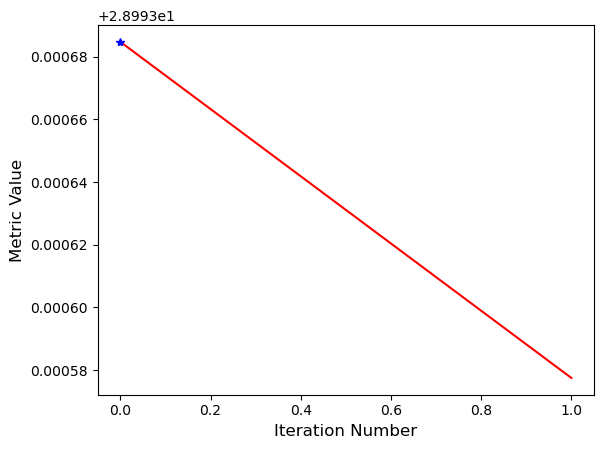

In [17]:
initTransform = sitk.CenteredTransformInitializer(
    fixed_image, moving_image, sitk.Euler3DTransform(), 
    sitk.CenteredTransformInitializerFilter.GEOMETRY
)

R.SetInitialTransform(initTransform, inPlace=False)
tform_reg_centered = R.Execute(fixed_image, moving_image)

Estimated Transformation Matrix
[[ 1.00000000e+00  1.08059350e-05 -1.79946313e-05  1.13100344e-03]
 [-1.73988716e-05  9.06289473e-01 -4.22657533e-01  1.11651414e+01]
 [ 1.17411351e-05  4.22657533e-01  9.06289473e-01  3.06333621e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Applied Transformation Matrix
[[ 1.          0.          0.          0.        ]
 [ 0.          0.90630779  0.42261826  0.        ]
 [ 0.         -0.42261826  0.90630779  0.        ]
 [ 0.          0.          0.          1.        ]]


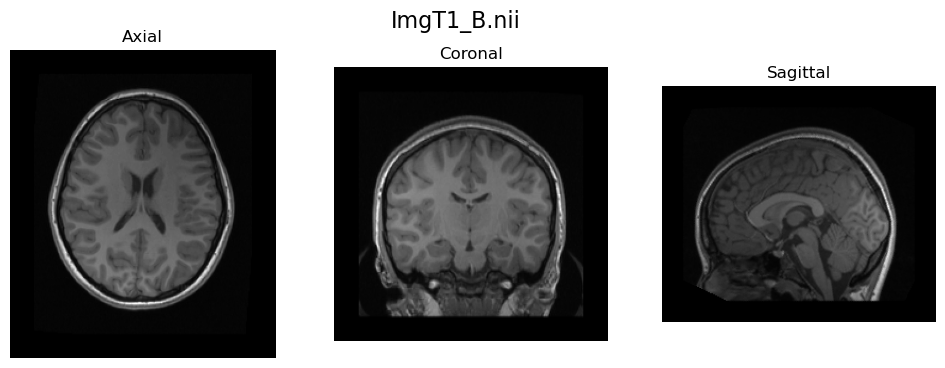

In [16]:
imshow_orthogonal_view(ImgT1_B, title='ImgT1_B.nii')
# Display the optimal affine matrix found
print('Estimated Transformation Matrix')
print(matrix_estimated)
print('\nApplied Transformation Matrix')
print(matrix_applied)

## Exercise 8

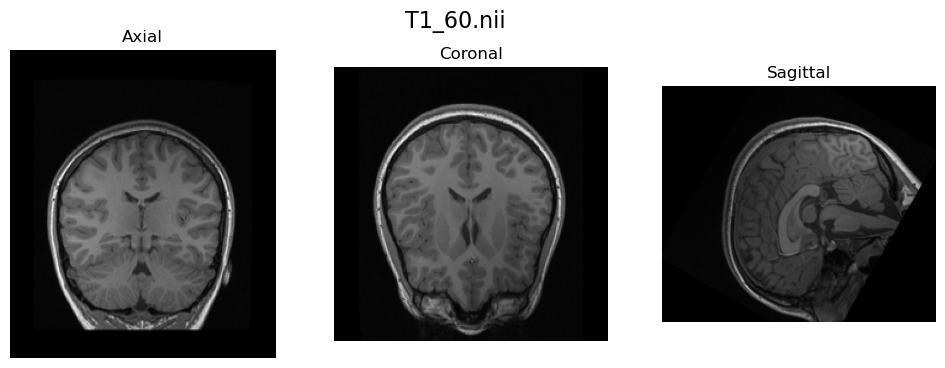

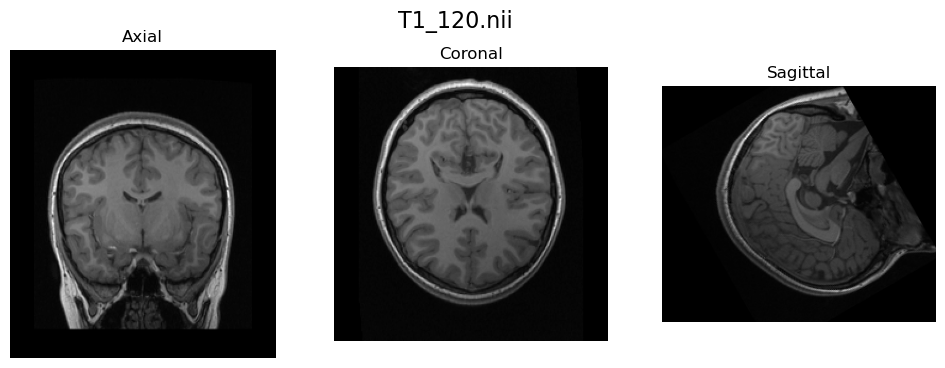

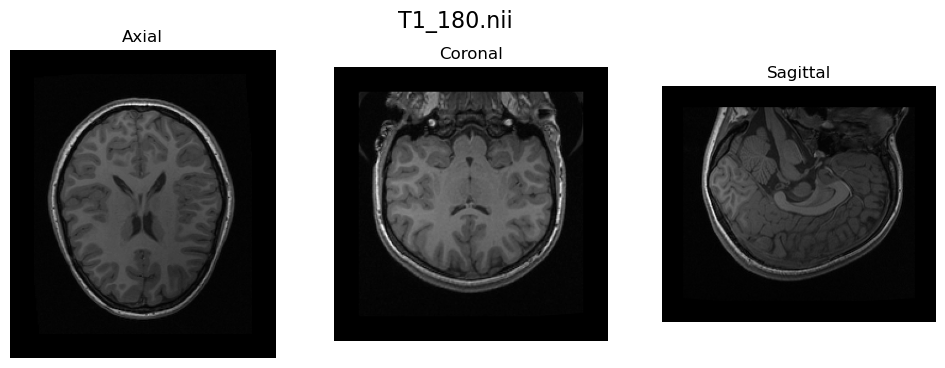

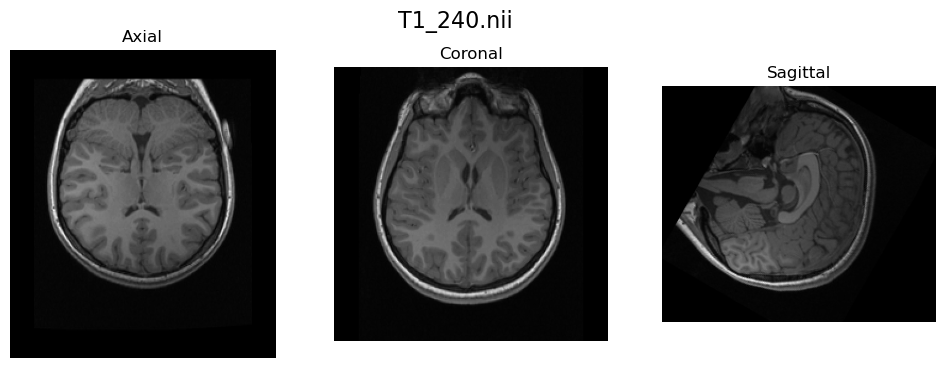

In [20]:
angles = [60, 120, 180, 240]
rotated_images = []

for angle in angles:
    
    rot_matrix = rotation_matrix(angle, 0, 0)[:3, :3]
    transform.SetMatrix(rot_matrix.T.flatten())
    
    rotated_img = sitk.Resample(vol_sitk, transform)
    rotated_images.append(rotated_img)
    sitk.WriteImage(rotated_img, f'{dir_in}ImgT1_{angle}.nii')

imshow_orthogonal_view(rotated_images[0], title='T1_60.nii')
imshow_orthogonal_view(rotated_images[1], title='T1_120.nii')
imshow_orthogonal_view(rotated_images[2], title='T1_180.nii')
imshow_orthogonal_view(rotated_images[3], title='T1_240.nii')


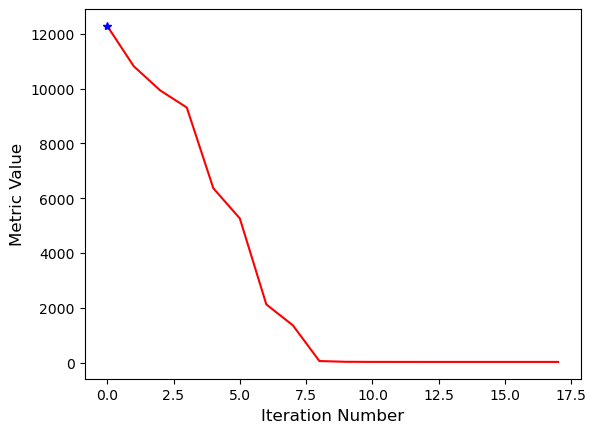

In [21]:
fixed_image = rotated_images[2]  # ImgT1_120.nii

for i, moving_image in enumerate([rotated_images[0], rotated_images[1], rotated_images[3]]):
    tform_reg = R.Execute(fixed_image, moving_image)
    resliced_image = sitk.Resample(moving_image, tform_reg)
    sitk.WriteImage(resliced_image, f'{dir_in}Ex9_{angles[i]}.nii')

## Exercise 10

In [ ]:
tform_60 = rotated_images[0]
tform_180 = rotated_images[1]
tform_240 = rotated_images[2]
tform_0 = rotated_images[3]

tform_composite = sitk.CompositeTransform(3)
for tform in [tform_240, tform_180, tform_60, tform_0]:
    tform_composite.AddTransform(tform.GetNthTransform(0))

affine_composite = composite2affine(tform_composite, centre_world)
final_img = sitk.Resample(vol_sitk, affine_composite)
imshow_orthogonal_view(final_img, title='Combined Transformation Result')


AttributeError: 'Image' object has no attribute 'GetNthTransform'